### About This Explainer

Once the sentiment classifier is sufficiently trained, we computed the explainer models to represent each token’s contribution to the overall sentiment classification. We first created a subset of our combined dataset for each prescription medication. We then tokenized each subset using the aforementioned tokenizer. The explainer models then iteratively masks the input tokens and measures classifier output changes to compute each token’s contributions to the overall sentiment classification. This SHAP-based explainer produced a token-contribution matrix for all documents, which were then averaged to create a global token-contribution matrix for each medication.

### Import Statements

In [1]:
import torch

from src.dataset import ReviewDataset
from src.dataloader_raw import ReviewDataLoader
from src.tokenizer import Tokenizer
from src.classifier_binary import Classifier
from src.explainer_binary_shap import Explainer, Explanation

### Environment Variables

In [2]:
data_path_all = "../../data/all.csv"
state_dict_path = "../../models/binary_classifier_model_best.pt"
out_path = "../../explanations/shap/"
model = "google-bert/bert-base-uncased"
max_length = 256
batch_size = 64

### Load Data

In [3]:
dataset_all = ReviewDataset(data_path_all)
drug_names = dataset_all.get_drug_names()
data_subsets = []
for drug_name in drug_names:
    data_subsets.append({
        "drug_name": drug_name,
        "dataset": dataset_all.get_subset_drug_name(drug_name)
    })

### Initialize Tokenizer

In [4]:
tokenizer = Tokenizer(model, max_length)

### Initialize Classifier

In [5]:
classifier = Classifier(model)
classifier.load_state_dict(torch.load(state_dict_path))

<All keys matched successfully>

### Initialize Explainer

In [6]:
explainer = Explainer(classifier, tokenizer)

### Explain

In [7]:
for data_subset in data_subsets:
    drug_name = data_subset["drug_name"]
    subset = data_subset["dataset"]
    dataloader = ReviewDataLoader(subset, batch_size, shuffle=False)
    explanation = Explanation()
    for batch in dataloader:
       explanation = explanation.union(explainer(batch))
    explanation.save(f"{out_path}/explanation_{drug_name}.json")

PartitionExplainer explainer: 65it [00:47,  1.14it/s]
PartitionExplainer explainer: 65it [00:38,  1.21it/s]
PartitionExplainer explainer: 65it [00:37,  1.21it/s]
PartitionExplainer explainer: 65it [00:37,  1.27it/s]


### Load Explanation

In [8]:
drug_name = "mirtazapine"
explanation = Explanation().load(f"{out_path}/explanation_{drug_name}.json")

### Explore Explanations

In [9]:
print("Drug name:", drug_name)
print("Top positive tokens: ")
print(explanation.get_top_positive_tuples(5))
print("Top negative tokens: ")
print(explanation.get_top_negative_tuples(5))

Drug name: mirtazapine
Top positive tokens: 
[('heavenly', 1.4053997348994018), ('Rapid ', 1.3384789258241654), ('Amazing ', 1.3269820536176362), ('Amazing', 1.177428359763733), ('Living ', 1.0788200159448926)]
Top negative tokens: 
[('Cannot ', 1.1529483278397994), ('Otherwise', 1.0125417732964868), ('Causes ', 0.9178164572351508), ('rage', 0.8456822616680644), ('headed ', 0.8075047742161485)]


### Visualize Explanations

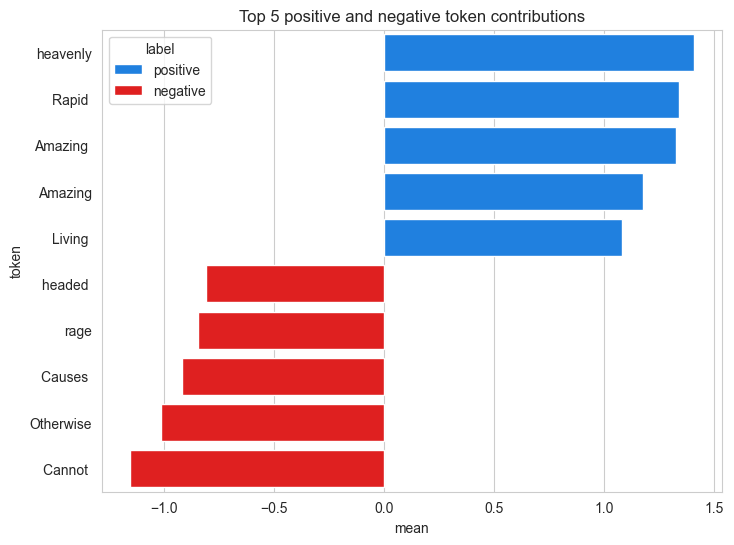

In [10]:
explanation.plot_top_tokens(5)